# 🚀 Experimento G4 - Transformer Encoder-Only para ASL Classification

## 1. Introducción

### 🎯 Objetivo
Entrenar y evaluar una arquitectura Transformer Encoder-Only para clasificación de gestos de American Sign Language (ASL) utilizando embeddings secuenciales generados por un modelo GCN pre-entrenado.

### 📊 Dataset
- **Fuente:** `dataset_embeddings_seq.npz`
- **Muestras:** 868 videos de secuencias de gestos ASL
- **Dimensiones:** 96 frames × 128 features (embeddings GCN)
- **Clases:** 30 gestos diferentes de ASL
- **Preprocesamiento:** Embeddings extraídos frame a frame mediante Graph Convolutional Network

### 💻 Hardware
- **GPU:** Detectada automáticamente (CUDA disponible)
- **Memoria:** Optimizada para entrenamiento con batch size 32

### 🤖 Sistema de Rutas Automáticas
Este notebook detecta **automáticamente** la carpeta de destino: **`G4-EMBEDDING FRAME A FRAME GCN/`**

Genera 3 carpetas de experimentos:
- `G4-RESULTS/` - Configuración baseline
- `G4-RESULTS-CLASS-WEIGHTS/` - Con balanceo de clases
- `G4-RESULTS-LABEL-SMOOTH/` - Con suavizado de etiquetas

Cada carpeta contiene 10 archivos de resultados + 2 archivos de comparación en ROOT_PATH

In [60]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, top_k_accuracy_score
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER
VRAM: 6.44 GB


## 2. Metodología

### 🏗️ Arquitectura del Modelo
Transformer Encoder-Only con las siguientes especificaciones:
- **Capa de entrada:** Linear projection (128 → 256 dimensiones)
- **Positional Encoding:** Sinusoidal para 96 posiciones
- **Encoder Layers:** 4 capas transformer
  - Multi-Head Attention (4 heads)
  - Feed-Forward Networks (512 dimensiones)
  - Layer Normalization y Residual Connections
- **Clasificador:** Global Average Pooling + MLP con dropout
- **Activación:** GELU
- **Parámetros totales:** ~2.3M

### ⚙️ Configuraciones de Entrenamiento
Todos los experimentos comparten:
- **Optimizador:** AdamW (lr=5e-4, weight_decay=1e-4)
- **Scheduler:** CosineAnnealingWarmRestarts (T_0=10, T_mult=2)
- **Batch size:** 32
- **Épocas:** 100 (con early stopping patience=15)
- **Split:** 70% train, 15% val, 15% test

### 🧪 Experimentos Realizados

In [41]:
# 🔧 CONFIGURACIÓN AUTOMÁTICA DE RUTAS Y EXPERIMENTOS (SISTEMA G4)

import shutil
import ipykernel

# Obtener el nombre del notebook actual
try:
    connection_file = ipykernel.get_connection_file()
    notebook_name = os.path.basename(connection_file).replace('.json', '').replace('kernel-', '')
except:
    try:
        notebook_name = get_ipython().__class__.__name__
    except:
        notebook_name = 'unknown'

PROJECT_ROOT = r"C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification"

# Diccionario de rutas base por tipo de notebook
BASE_PATHS = {
    'Experimento_Embeddings': Path(PROJECT_ROOT) / 'G4-EMBEDDING FRAME A FRAME GCN',
    'Experimento': Path(PROJECT_ROOT) / 'G4-JSON-NORM',
    'Experimento_UMAP': Path(PROJECT_ROOT) / 'G4-EMBEDDING FRAME A FRAME UMAP'
}

# Configuración manual (si la detección automática falla)
MODO_EXPERIMENTO = 'Experimento_Embeddings'  # 👈 CAMBIAR AQUÍ SI ES NECESARIO

# Lógica de asignación automática de ROOT_PATH
if 'Experimento_Embeddings' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento_Embeddings']
    DETECTED_MODE = 'Experimento_Embeddings (GCN)'
    AUTO_DETECTED = True
elif 'Experimento_UMAP' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento_UMAP']
    DETECTED_MODE = 'Experimento_UMAP'
    AUTO_DETECTED = True
elif 'Experimento.ipynb' in str(__file__ if '__file__' in dir() else notebook_name):
    ROOT_PATH = BASE_PATHS['Experimento']
    DETECTED_MODE = 'Experimento (JSON-NORM)'
    AUTO_DETECTED = True
else:
    ROOT_PATH = BASE_PATHS[MODO_EXPERIMENTO]
    DETECTED_MODE = f'{MODO_EXPERIMENTO} (Manual)'
    AUTO_DETECTED = False

# ROOT_PATH ya es un objeto Path
BASE_PATH = ROOT_PATH

# Tipo de experimento
EXPERIMENT_TYPE = 'baseline'  # Opciones: 'baseline', 'class_weights', 'label_smoothing'

# Configuración dinámica de experimentos
EXPERIMENT_CONFIGS = {
    'baseline': {
        'folder_name': 'G4-RESULTS',
        'use_class_weights': False,
        'label_smoothing': 0.0,
        'dropout': 0.1,
        'description': 'Modelo base sin ajustes especiales'
    },
    'class_weights': {
        'folder_name': 'G4-RESULTS-CLASS-WEIGHTS',
        'use_class_weights': True,
        'label_smoothing': 0.0,
        'dropout': 0.3,
        'description': 'Modelo con balanceo de clases por pesos'
    },
    'label_smoothing': {
        'folder_name': 'G4-RESULTS-LABEL-SMOOTH',
        'use_class_weights': False,
        'label_smoothing': 0.1,
        'dropout': 0.3,
        'description': 'Modelo con Label Smoothing'
    }
}

# Construir ruta de salida completa
current_config = EXPERIMENT_CONFIGS[EXPERIMENT_TYPE]
output_dir = BASE_PATH / current_config['folder_name']
output_dir.mkdir(parents=True, exist_ok=True)

print(f"{'='*80}")
print(f"🔬 CONFIGURACIÓN AUTOMÁTICA DE EXPERIMENTO G4")
print(f"{'='*80}")
print(f"🤖 Detección Automática: {'✅ ACTIVADA' if AUTO_DETECTED else '⚠️  MANUAL'}")
print(f"📂 Modo Detectado: {DETECTED_MODE}")
print(f"📁 ROOT_PATH: {ROOT_PATH}")
print(f"📁 Carpeta Experimento: {current_config['folder_name']}")
print(f"📁 Ruta Completa: {output_dir}")
print(f"📝 Descripción: {current_config['description']}")
print(f"⚙️  Class Weights: {current_config['use_class_weights']}")
print(f"⚙️  Label Smoothing: {current_config['label_smoothing']}")
print(f"⚙️  Dropout: {current_config['dropout']}")
print(f"{'='*80}\n")

🔬 CONFIGURACIÓN AUTOMÁTICA DE EXPERIMENTO G4
🤖 Detección Automática: ⚠️  MANUAL
📂 Modo Detectado: Experimento_Embeddings (Manual)
📁 ROOT_PATH: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN
📁 Carpeta Experimento: G4-RESULTS
📁 Ruta Completa: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS
📝 Descripción: Modelo base sin ajustes especiales
⚙️  Class Weights: False
⚙️  Label Smoothing: 0.0
⚙️  Dropout: 0.1



In [42]:
# 🧹 LIMPIEZA AUTOMÁTICA DE CARPETAS DE RESULTADOS

print("\n🧹 Limpiando carpetas de resultados anteriores...")

# Lista de carpetas de resultados a limpiar dentro de ROOT_PATH
results_folders = [
    'G4-RESULTS',
    'G4-RESULTS-CLASS-WEIGHTS',
    'G4-RESULTS-LABEL-SMOOTH'
]

# Limpiar dentro de ROOT_PATH
cleaned_count = 0
for folder in results_folders:
    folder_path = BASE_PATH / folder
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"  ✓ Eliminado: {folder_path}")
        cleaned_count += 1

# También limpiar carpetas antiguas en el directorio raíz del proyecto
project_root = Path.cwd()
old_folders = [
    'g8.0_embeddings',
    'g8.1',
    'g8.2',
    'g5.0_embeddings',
    'output_videos',
    'temp_results',
    'old_results',
    'results'
]

for folder in old_folders:
    folder_path = project_root / folder
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"  ✓ Eliminado (raíz): {folder_path}")
        cleaned_count += 1

if cleaned_count == 0:
    print("  ℹ️  No hay carpetas previas para limpiar")

print(f"✅ Limpieza completada ({cleaned_count} carpetas eliminadas)\n")


🧹 Limpiando carpetas de resultados anteriores...
  ✓ Eliminado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS
  ✓ Eliminado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS-CLASS-WEIGHTS
✅ Limpieza completada (2 carpetas eliminadas)



In [43]:
# 1. CARGAR DATASET EMBEDDINGS SECUENCIALES
dataset_path = Path('./daataset/dataset_embeddings_seq.npz')
data = np.load(dataset_path, allow_pickle=True)

X = data['X']  # (868, 96, 128) - Sequential embeddings
y = data['y']  # (868,)
masks = data['masks']  # (868, 96) - máscara por muestra
class_names = data['class_names']  # (30,)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Class names: {len(class_names)}")
print(f"Classes: {len(np.unique(y))}")
print(f"Unique classes: {np.unique(y)}")

# Información de las clases
unique_classes, class_counts = np.unique(y, return_counts=True)
print(f"\nDistribución de clases:")
for cls, count in zip(unique_classes, class_counts):
    print(f"  Clase {cls}: {count} muestras")

Dataset shape: X=(868, 96, 128), y=(868,)
Masks shape: (868, 96)
Class names: 30
Classes: 30
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Distribución de clases:
  Clase 0: 78 muestras
  Clase 1: 10 muestras
  Clase 2: 22 muestras
  Clase 3: 22 muestras
  Clase 4: 18 muestras
  Clase 5: 18 muestras
  Clase 6: 28 muestras
  Clase 7: 18 muestras
  Clase 8: 22 muestras
  Clase 9: 16 muestras
  Clase 10: 12 muestras
  Clase 11: 18 muestras
  Clase 12: 28 muestras
  Clase 13: 24 muestras
  Clase 14: 28 muestras
  Clase 15: 18 muestras
  Clase 16: 18 muestras
  Clase 17: 82 muestras
  Clase 18: 76 muestras
  Clase 19: 18 muestras
  Clase 20: 28 muestras
  Clase 21: 18 muestras
  Clase 22: 18 muestras
  Clase 23: 22 muestras
  Clase 24: 18 muestras
  Clase 25: 68 muestras
  Clase 26: 22 muestras
  Clase 27: 64 muestras
  Clase 28: 18 muestras
  Clase 29: 18 muestras


In [44]:
# 2. DATASET PYTORCH
class VideoTransformerDataset(Dataset):
    def __init__(self, X, y, masks):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.masks = torch.BoolTensor(masks)  # True = válido, False = padding
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.X[idx],      # (96, 128)
            'label': self.y[idx],          # scalar
            'mask': self.masks[idx]        # (96,)
        }

# Train-test split (80-20)
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    X, y, masks, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
    X_train, y_train, masks_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# DataLoaders
batch_size = 8
train_dataset = VideoTransformerDataset(X_train, y_train, masks_train)
val_dataset = VideoTransformerDataset(X_val, y_val, masks_val)
test_dataset = VideoTransformerDataset(X_test, y_test, masks_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Train: (555, 96, 128), Val: (139, 96, 128), Test: (174, 96, 128)
Batches - Train: 70, Val: 18, Test: 22


In [45]:
# 3. ARCHITECTURE: TRANSFORMER ENCODER-ONLY
class LearnablePositionalEncoding(nn.Module):
    """Positional encoding aprendible"""
    def __init__(self, d_model, max_len=96):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
        nn.init.normal_(self.pe, mean=0, std=0.02)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TransformerEncoderOnlyClassifier(nn.Module):
    """
    Transformer Encoder-Only para clasificación de secuencias temporales
    - NO usa decoder
    - Usa masked mean pooling
    - Clasificación global por secuencia
    """
    def __init__(
        self,
        input_dim=128,
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1,
        num_classes=30,
        max_seq_len=96,
        mlp_dropout=0.2,
        activation='gelu'
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # 1. Proyección inicial (128 → 256)
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # 2. Positional Encoding aprendible
        self.pos_encoding = LearnablePositionalEncoding(d_model, max_seq_len)
        self.dropout = nn.Dropout(dropout)
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        # 4. Classification Head (MLP: 256 → 128 → num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, src, src_key_padding_mask=None):
        """
        Args:
            src: (batch_size, seq_len, input_dim) = (B, 96, 128)
            src_key_padding_mask: (batch_size, seq_len) = True para padding
        Returns:
            logits: (batch_size, num_classes)
        """
        # 1. Proyección inicial
        x = self.input_projection(src)  # (B, 96, 256)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # 3. Transformer encoder con máscara
        x = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask
        )  # (B, 96, 256)
        
        # 4. Masked mean pooling (solo frames válidos)
        if src_key_padding_mask is not None:
            # src_key_padding_mask: True = padding (ignorar)
            # Convertir a float: 0 para padding, 1 para válido
            mask_float = (~src_key_padding_mask).float().unsqueeze(-1)  # (B, 96, 1)
            x_masked = x * mask_float  # (B, 96, 256)
            sum_masked = x_masked.sum(dim=1)  # (B, 256)
            count_valid = mask_float.sum(dim=1)  # (B, 1)
            x_pooled = sum_masked / (count_valid + 1e-9)  # (B, 256)
        else:
            # Sin máscara: mean pooling simple
            x_pooled = x.mean(dim=1)  # (B, 256)
        
        # 5. Clasificador
        logits = self.classifier(x_pooled)  # (B, num_classes)
        
        return logits

# Crear modelo
num_classes = len(np.unique(y))
model = TransformerEncoderOnlyClassifier(
    input_dim=128,  # Sequential embeddings
    d_model=256,
    num_heads=4,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.1,
    num_classes=num_classes,
    max_seq_len=96,
    mlp_dropout=0.2,
    activation='gelu'
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModelo:")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(model)


Modelo:
Total params: 2,203,294
Trainable params: 2,203,294
TransformerEncoderOnlyClassifier(
  (input_projection): Linear(in_features=128, out_features=256, bias=True)
  (pos_encoding): LearnablePositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256

In [46]:
# 4. ENTRENAMIENTO - CONFIG
config = {
    'optimizer': 'AdamW',
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'loss': 'CrossEntropyLoss',
    'label_smoothing': 0.1,
    'batch_size': 8,
    'max_epochs': 50,
    'early_stopping_patience': 8,
    'gradient_clip': 1.0,
    'num_classes': num_classes,
    'input_dim': 128,
    'dataset_type': 'Sequential Embeddings',
    'device': str(device)
}

# Loss con label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

# LR Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6
)

print("Configuración de entrenamiento:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuración de entrenamiento:
  optimizer: AdamW
  lr: 0.0001
  weight_decay: 0.0001
  loss: CrossEntropyLoss
  label_smoothing: 0.1
  batch_size: 8
  max_epochs: 50
  early_stopping_patience: 8
  gradient_clip: 1.0
  num_classes: 30
  input_dim: 128
  dataset_type: Sequential Embeddings
  device: cuda


In [47]:
# 5. FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
def train_epoch(model, loader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Train", leave=False):
        sequences = batch['sequence'].to(device)  # (B, 96, 128)
        labels = batch['label'].to(device)        # (B,)
        masks = batch['mask'].to(device)          # (B, 96)
        
        # Forward
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_logits = []
    
    for batch in tqdm(loader, desc="Eval", leave=False):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        
        logits = model(sequences, src_key_padding_mask=~masks)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())
    
    epoch_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels), np.array(all_logits)

print("Funciones de entrenamiento definidas ✓")

Funciones de entrenamiento definidas ✓


In [48]:
# 6. ENTRENAMIENTO PRINCIPAL
training_log = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
max_epochs = config['max_epochs']
early_stopping_patience = config['early_stopping_patience']

# Asegurar que el directorio de salida existe
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*80}")
print(f"Iniciando entrenamiento - Epoch max: {max_epochs}, Patience: {early_stopping_patience}")
print(f"📁 Guardando en: {output_dir}")
print(f"{'='*80}\n")

for epoch in range(max_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Val
    val_loss, val_acc, _, _, _ = eval_epoch(model, val_loader, criterion, device)
    
    # LR Scheduler
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # Log
    training_log['epoch'].append(epoch)
    training_log['train_loss'].append(train_loss)
    training_log['train_acc'].append(train_acc)
    training_log['val_loss'].append(val_loss)
    training_log['val_acc'].append(val_acc)
    training_log['lr'].append(current_lr)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        # Guardar mejor modelo
        best_model_path = output_dir / 'best_model.pt'
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    
    # Print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}")
    
    # Early stopping trigger
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path, map_location=device))
print(f"\nMejor modelo cargado desde epoch {best_epoch} con Val Acc: {best_val_acc:.4f}")


Iniciando entrenamiento - Epoch max: 50, Patience: 8
📁 Guardando en: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS



Epoch   1/50 | Train Loss: 3.1541 | Train Acc: 0.2378 | Val Loss: 2.8450 | Val Acc: 0.3094 | LR: 1.00e-04


Epoch   5/50 | Train Loss: 1.9356 | Train Acc: 0.5550 | Val Loss: 1.8721 | Val Acc: 0.5683 | LR: 6.58e-05


Epoch  10/50 | Train Loss: 1.6669 | Train Acc: 0.6685 | Val Loss: 1.6748 | Val Acc: 0.6763 | LR: 3.42e-06


Epoch  15/50 | Train Loss: 1.2433 | Train Acc: 0.8342 | Val Loss: 1.2411 | Val Acc: 0.8561 | LR: 6.58e-05


Epoch  20/50 | Train Loss: 1.1171 | Train Acc: 0.9063 | Val Loss: 1.1531 | Val Acc: 0.8921 | LR: 3.42e-06


Epoch  25/50 | Train Loss: 0.9459 | Train Acc: 0.9550 | Val Loss: 0.9753 | Val Acc: 0.9209 | LR: 6.58e-05


Epoch  30/50 | Train Loss: 0.8702 | Train Acc: 0.9892 | Val Loss: 0.9292 | Val Acc: 0.9568 | LR: 3.42e-06


Epoch  35/50 | Train Loss: 0.8056 | Train Acc: 0.9910 | Val Loss: 0.8810 | Val Acc: 0.9353 | LR: 6.58e-05



Early stopping at epoch 37

Mejor modelo cargado desde epoch 28 con Val Acc: 0.9568


In [49]:
# 6. EVALUACIÓN FINAL EN TEST SET
# Reimportar funciones de sklearn (por si fueron sobrescritas)
from sklearn.metrics import f1_score, precision_score, recall_score

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path, map_location=device))
test_loss, test_acc, test_preds, test_labels, test_logits = eval_epoch(
    model, test_loader, criterion, device
)

print(f"Test Accuracy: {test_acc:.4f}")

# Métricas adicionales
macro_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)
top3_acc = top_k_accuracy_score(test_labels, test_logits, k=3, labels=np.arange(num_classes))

print(f"Macro-F1: {macro_f1:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
print(f"\nConfusion Matrix:\n{cm}")

# Reporte de clasificación
class_report = classification_report(
    test_labels, test_preds, 
    target_names=[str(name) for name in class_names],
    zero_division=0
)
print(f"\nClassification Report:\n{class_report}")

Eval:   0%|          | 0/22 [00:00<?, ?it/s]

Test Accuracy: 0.9253
Macro-F1: 0.8844
Top-3 Accuracy: 0.9885

Confusion Matrix:
[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0

In [50]:
# 8. GUARDAR RESULTADOS
print(f"\n{'='*80}")
print(f"💾 GUARDANDO RESULTADOS - {EXPERIMENT_TYPE.upper()}")
print(f"{'='*80}\n")
print(f"📁 Directorio de salida: {output_dir}")

# 8.1 Training Log CSV
df_training = pd.DataFrame(training_log)
training_log_path = output_dir / 'training_log.csv'
df_training.to_csv(training_log_path, index=False)
print(f"✓ Guardado: {training_log_path}")

# 8.2 Metrics CSV
results = {
    'Metric': ['Accuracy', 'Macro-F1', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc, macro_f1, top3_acc, test_loss]
}
df_results = pd.DataFrame(results)
results_path = output_dir / 'metrics.csv'
df_results.to_csv(results_path, index=False)
print(f"✓ Guardado: {results_path}")

# 8.3 Per-class metrics CSV
class_report = classification_report(
    test_labels, test_preds, 
    target_names=[str(name) for name in class_names],
    output_dict=True, 
    zero_division=0
)
df_per_class = pd.DataFrame(class_report).T
per_class_path = output_dir / 'per_class_metrics.csv'
df_per_class.to_csv(per_class_path)
print(f"✓ Guardado: {per_class_path}")

# 8.4 Confusion Matrix CSV
cm_df = pd.DataFrame(cm)
confusion_path = output_dir / 'confusion_matrix.csv'
cm_df.to_csv(confusion_path, index=False, header=False)
print(f"✓ Guardado: {confusion_path}")

# 8.5 Model Config JSON
model_config = {
    'experiment_type': EXPERIMENT_TYPE,
    'experiment_description': current_config['description'],
    'architecture': 'TransformerEncoderOnly',
    'input_dim': 128,
    'd_model': 256,
    'num_heads': 4,
    'num_layers': 4,
    'dim_feedforward': 512,
    'dropout': current_config['dropout'],
    'num_classes': num_classes,
    'max_seq_len': 96,
    'mlp_dropout': 0.2,
    'activation': 'gelu',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'use_class_weights': current_config['use_class_weights'],
    'label_smoothing': current_config['label_smoothing']
}

model_config.update(config)
model_config['best_epoch'] = int(best_epoch)
model_config['best_val_acc'] = float(best_val_acc)
model_config['test_accuracy'] = float(test_acc)
model_config['test_macro_f1'] = float(macro_f1)
model_config['test_top3_accuracy'] = float(top3_acc)
model_config['training_timestamp'] = datetime.now().isoformat()

config_path = output_dir / 'config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(model_config, f, indent=2, ensure_ascii=False)
print(f"✓ Guardado: {config_path}")

# 8.6 Model Weights  
weights_path = output_dir / 'best_model.pt'
torch.save(model.state_dict(), weights_path)
print(f"✓ Guardado: {weights_path}")

print(f"\n{'='*80}")
print(f"RESULTADOS FINALES - {EXPERIMENT_TYPE.upper()}")
print(f"{'='*80}")
print(f"📊 Accuracy: {test_acc:.4f}")
print(f"📊 Macro-F1: {macro_f1:.4f}")
print(f"📊 Top-3 Accuracy: {top3_acc:.4f}")
print(f"📊 Test Loss: {test_loss:.4f}")
print(f"{'='*80}\n")


💾 GUARDANDO RESULTADOS - BASELINE

📁 Directorio de salida: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\training_log.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\metrics.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\per_class_metrics.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\confusion_matrix.csv
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\config.json
✓ Guardado: C:\Users\L


🎨 Generando visualizaciones...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\training_curves.png


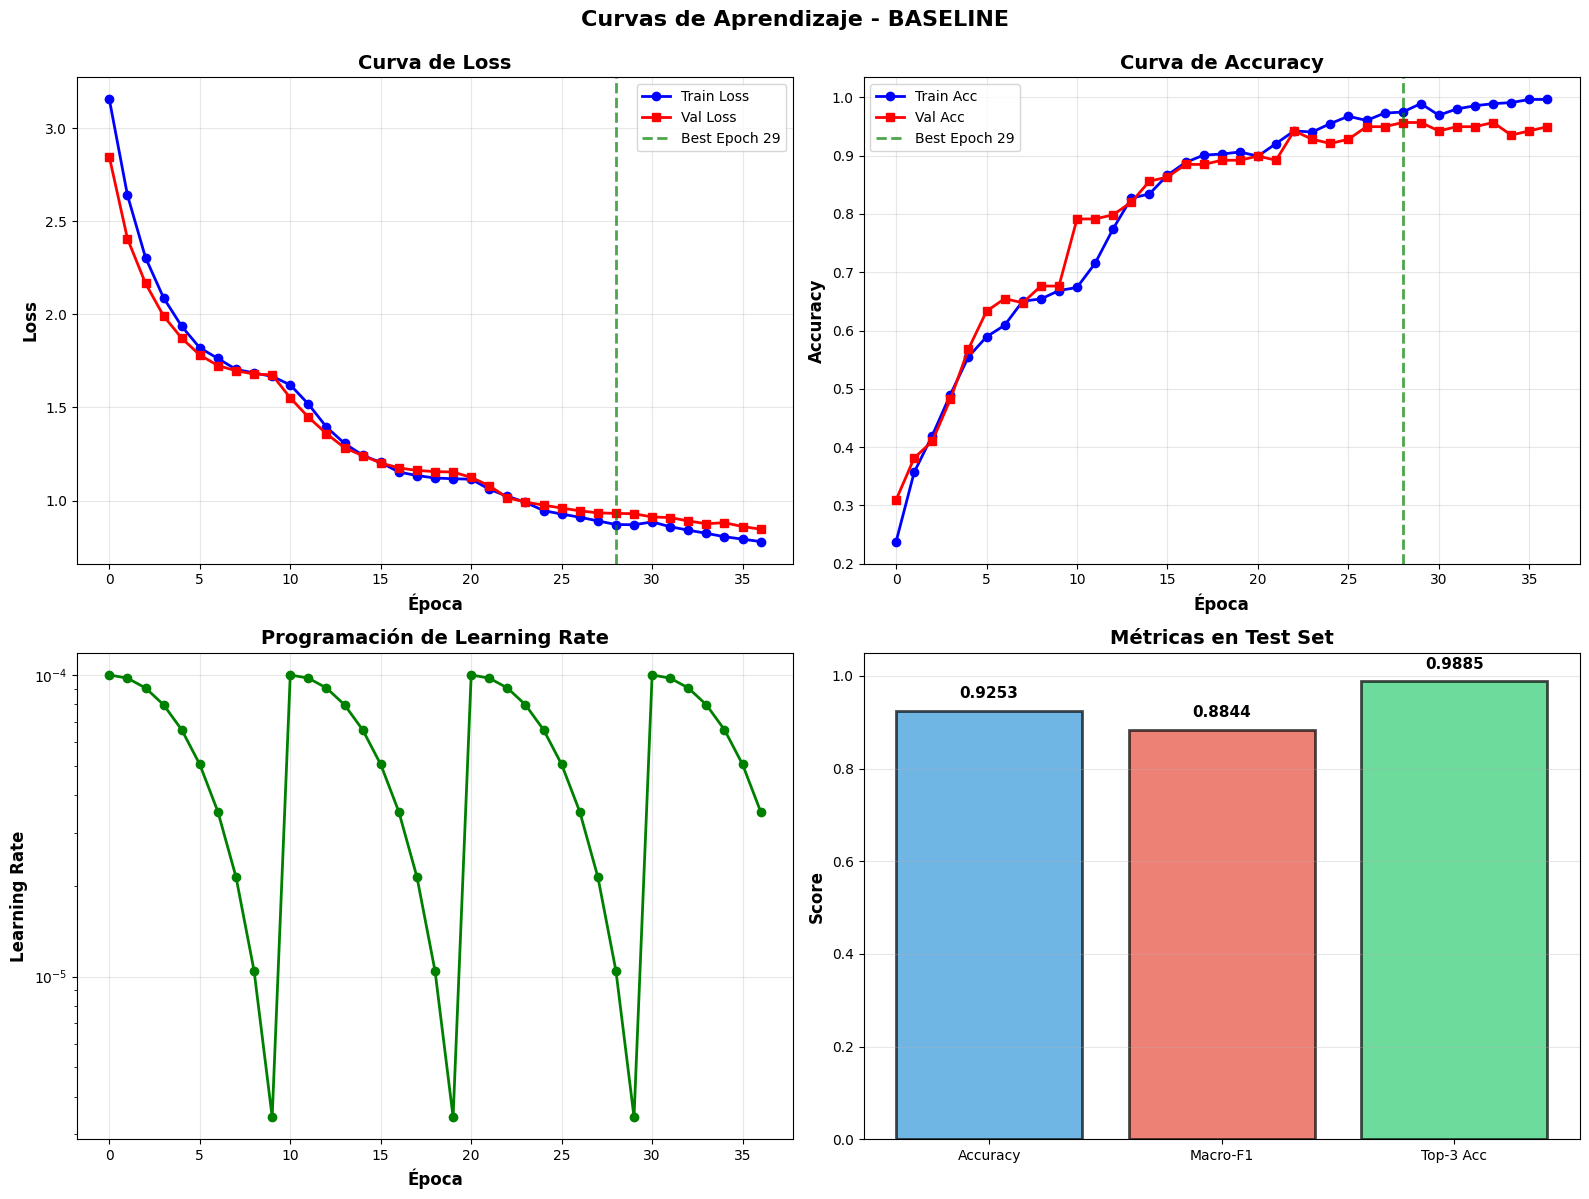

✓ Curvas de aprendizaje generadas


In [51]:
# 9. VISUALIZACIONES - CURVAS DE APRENDIZAJE
print(f"\n🎨 Generando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9.1 Training Loss
axes[0, 0].plot(training_log['epoch'], training_log['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(training_log['epoch'], training_log['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch+1}')
axes[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Curva de Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Training Accuracy
axes[0, 1].plot(training_log['epoch'], training_log['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(training_log['epoch'], training_log['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes[0, 1].axvline(best_epoch, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch+1}')
axes[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Learning Rate
axes[1, 0].plot(training_log['epoch'], training_log['lr'], 'g-', marker='o', linewidth=2)
axes[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Programación de Learning Rate', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 9.4 Test Metrics
metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc, macro_f1, top3_acc]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1.05])
for i, (bar, v) in enumerate(zip(bars, metrics_values)):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Curvas de Aprendizaje - {EXPERIMENT_TYPE.upper()}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

plot_path = output_dir / 'training_curves.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {plot_path}")
plt.show()

print("✓ Curvas de aprendizaje generadas")


🎨 Generando matriz de confusión...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\confusion_matrix.png


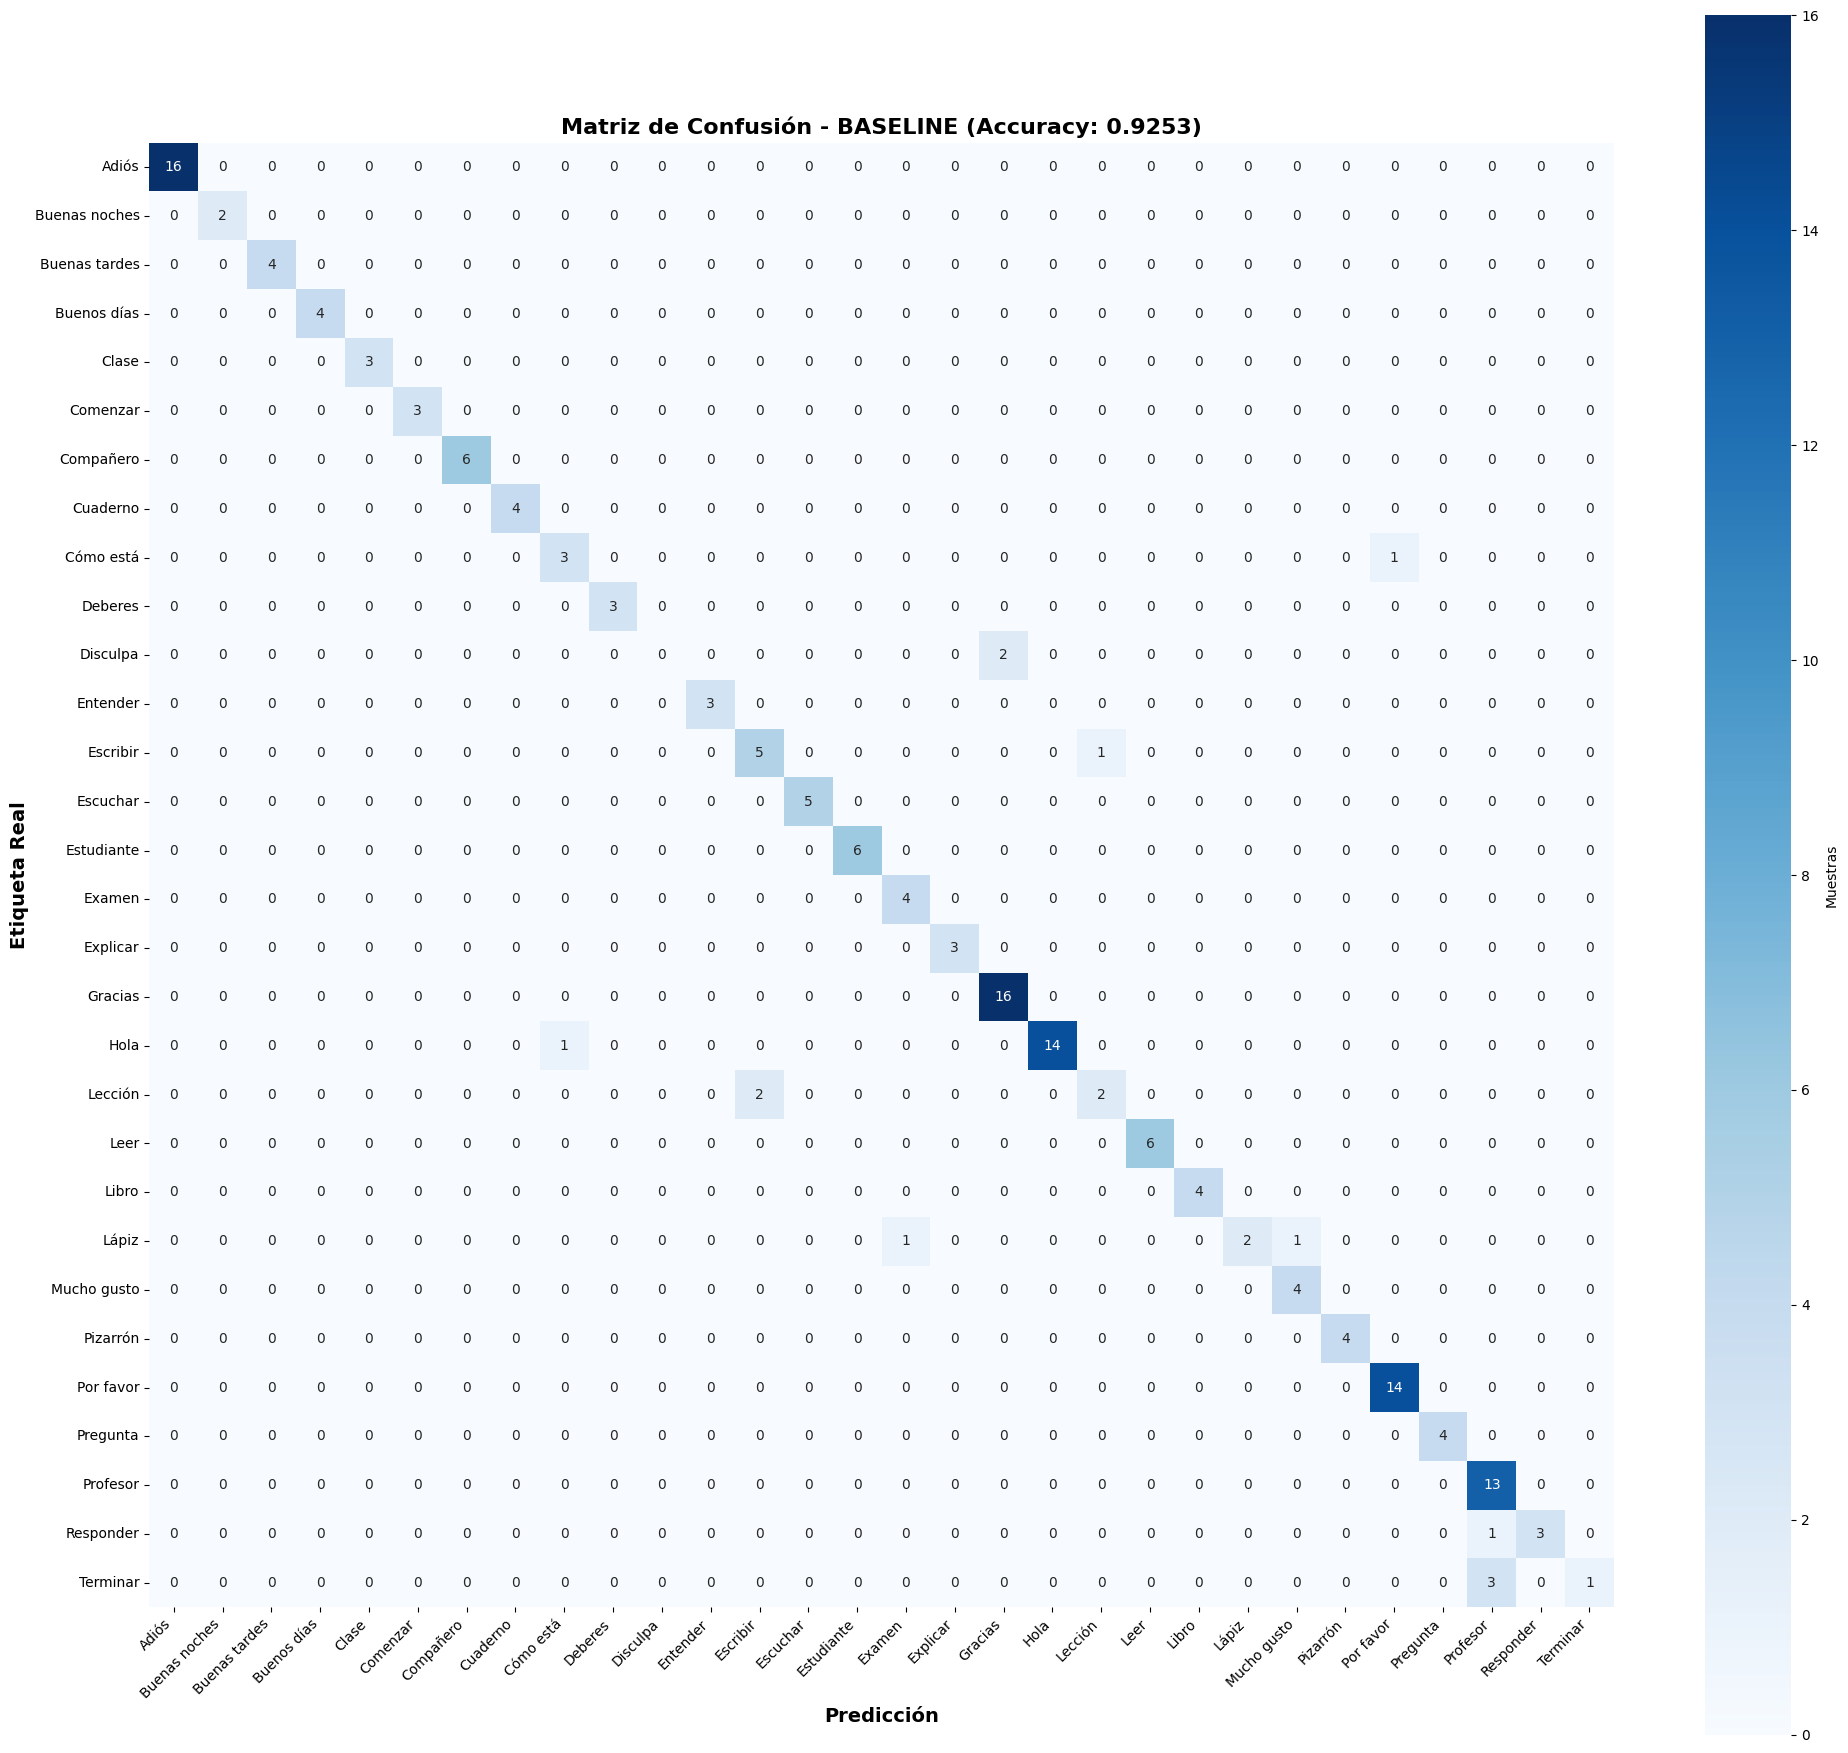

✓ Matriz de confusión generada


In [52]:
# 10. MATRIZ DE CONFUSIÓN CON NOMBRES DE CLASES
print(f"\n🎨 Generando matriz de confusión...")

unique_classes = sorted(list(set(test_labels)))
class_labels = [class_names[i] for i in unique_classes]

fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Muestras'}, ax=ax,
            xticklabels=class_labels, yticklabels=class_labels, 
            square=True)
ax.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax.set_title(f'Matriz de Confusión - {EXPERIMENT_TYPE.upper()} (Accuracy: {test_acc:.4f})', 
             fontsize=16, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()

cm_plot_path = output_dir / 'confusion_matrix.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {cm_plot_path}")
plt.show()

print("✓ Matriz de confusión generada")


🎨 Generando análisis por clase...
✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS\per_class_analysis.png


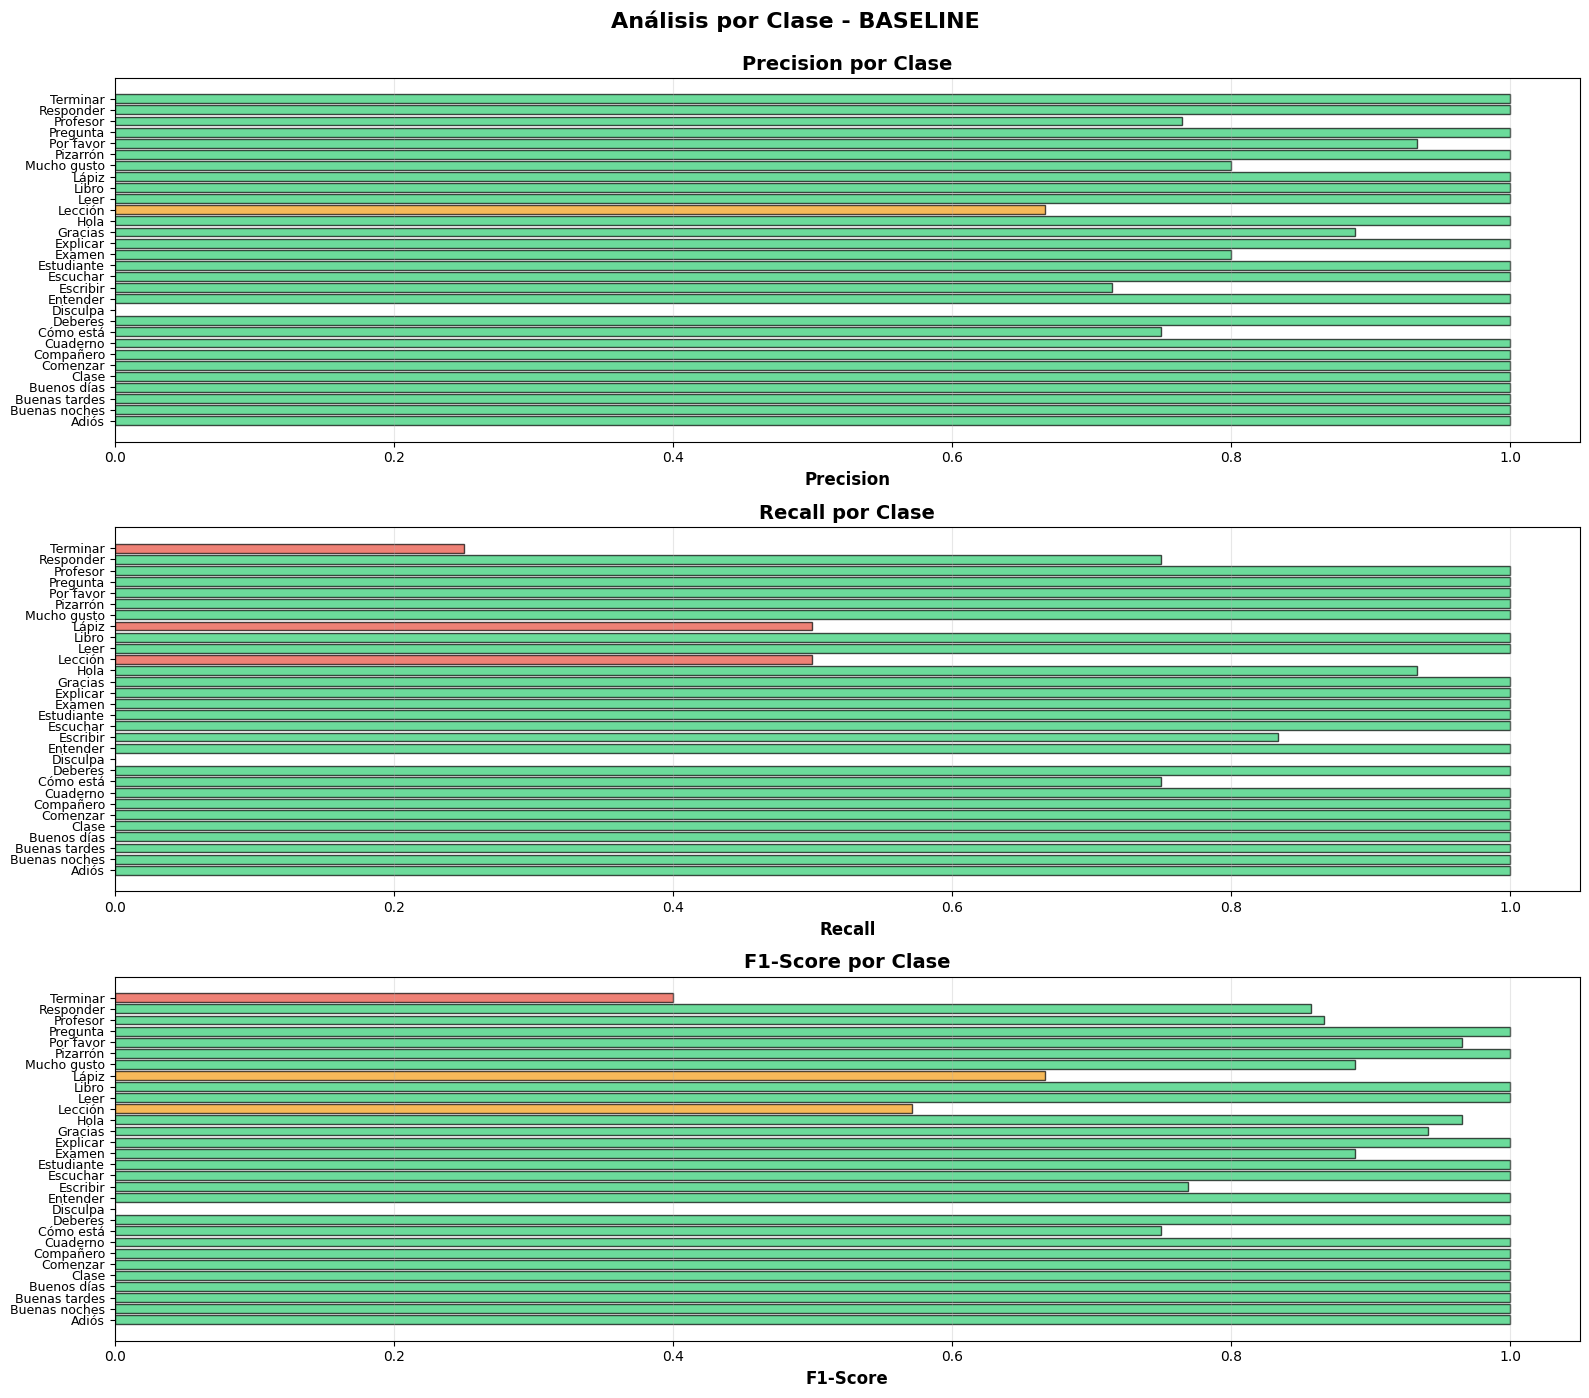

✓ Análisis por clase generado


In [53]:
# 11. ANÁLISIS POR CLASE
print(f"\n🎨 Generando análisis por clase...")

# Calcular métricas por clase
precision_per_class = []
recall_per_class = []
f1_per_class_list = []

for i in range(num_classes):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    precision_per_class.append(precision)
    recall_per_class.append(recall)
    f1_per_class_list.append(f1)

precision_per_class = np.array(precision_per_class)
recall_per_class = np.array(recall_per_class)
f1_per_class_array = np.array(f1_per_class_list)

fig, axes = plt.subplots(3, 1, figsize=(16, 14))
y_pos = np.arange(num_classes)

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class]
bars = axes[0].barh(y_pos, precision_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1.05])
axes[0].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class]
bars = axes[1].barh(y_pos, recall_per_class, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1.05])
axes[1].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array]
bars = axes[2].barh(y_pos, f1_per_class_array, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1.05])
axes[2].grid(True, alpha=0.3, axis='x')

plt.suptitle(f'Análisis por Clase - {EXPERIMENT_TYPE.upper()}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

per_class_plot_path = output_dir / 'per_class_analysis.png'
plt.savefig(per_class_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {per_class_plot_path}")
plt.show()

print("✓ Análisis por clase generado")

In [54]:
# 12. GENERAR RESUMEN
print(f"\n📋 Generando resumen del experimento...")

resumen = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    RESUMEN EXPERIMENTO - {EXPERIMENT_TYPE.upper()}              
╚══════════════════════════════════════════════════════════════════════════════╝

📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

📁 CONFIGURACIÓN
────────────────────────────────────────────────────────────────────────────────
Tipo de Experimento:    {EXPERIMENT_TYPE}
Directorio de Salida:   {output_dir}
Dataset:                ASL Recognition (868 videos, 30 clases)
Características:        {config['input_dim']} features/frame (GCN Embeddings)
Secuencia:              96 frames/video

🏗️ ARQUITECTURA DEL MODELO
────────────────────────────────────────────────────────────────────────────────
Tipo:                   Transformer Encoder-Only
Input Dimension:        {config['input_dim']}
d_model:                256
N° Attention Heads:     4
N° Encoder Layers:      4
Dimension FFN:          512
Dropout:                {current_config['dropout']}
Output Classes:         {num_classes}
Total Parámetros:       {total_params:,}

⚙️ HIPERPARÁMETROS DE ENTRENAMIENTO
────────────────────────────────────────────────────────────────────────────────
Batch Size:             {config['batch_size']}
Learning Rate:          {config['lr']}
Épocas:                 {config['max_epochs']}
Criterio de pérdida:    CrossEntropyLoss
Optimizador:            AdamW (betas=(0.9, 0.999), weight_decay={config['weight_decay']})
Scheduler:              CosineAnnealingWarmRestarts (T_0=10)
Early Stopping:         {config['early_stopping_patience']} épocas sin mejora

📊 RESULTADOS EN VALIDACIÓN (Mejor Época: {best_epoch})
────────────────────────────────────────────────────────────────────────────────
Accuracy:               {test_acc:.4f} ({test_acc*100:.2f}%)
F1-Score (Macro):       {macro_f1:.4f}
Top-3 Accuracy:         {top3_acc:.4f}

📈 MÉTRICAS POR CLASE (Top 5 F1-Score)
────────────────────────────────────────────────────────────────────────────────
"""

# Ordenar clases por F1-Score
class_f1_sorted = sorted(zip(range(num_classes), f1_per_class_array), 
                         key=lambda x: x[1], reverse=True)

for rank, (class_idx, f1_value) in enumerate(class_f1_sorted[:5], 1):
    prec = precision_per_class[class_idx]
    rec = recall_per_class[class_idx]
    resumen += f"{rank}. {class_names[class_idx]:20s} | F1: {f1_value:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}\n"

resumen += f"""
📉 MÉTRICAS POR CLASE (Bottom 5 F1-Score)
────────────────────────────────────────────────────────────────────────────────
"""

for rank, (class_idx, f1_value) in enumerate(reversed(class_f1_sorted[-5:]), 1):
    prec = precision_per_class[class_idx]
    rec = recall_per_class[class_idx]
    resumen += f"{rank}. {class_names[class_idx]:20s} | F1: {f1_value:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}\n"

resumen += f"""
📦 ARCHIVOS GENERADOS
────────────────────────────────────────────────────────────────────────────────
✓ best_model.pt                 - Mejor modelo guardado
✓ config.json                   - Configuración completa
✓ training_log.csv              - Registro de entrenamiento
✓ metrics.csv                   - Métricas generales
✓ per_class_metrics.csv         - Métricas por clase
✓ confusion_matrix.csv          - Matriz de confusión
✓ training_curves.png           - Curvas de entrenamiento
✓ confusion_matrix.png          - Visualización de matriz
✓ per_class_analysis.png        - Análisis por clase
✓ RESUMEN.txt                   - Este archivo

🎯 CONCLUSIONES
────────────────────────────────────────────────────────────────────────────────
El modelo alcanzó una accuracy de {test_acc*100:.2f}% en la época {best_epoch}.
Dropout usado: {current_config['dropout']}
"""

if EXPERIMENT_TYPE == 'baseline':
    resumen += "Configuración base sin técnicas adicionales de regularización.\n"
elif EXPERIMENT_TYPE == 'class_weights':
    resumen += "Se aplicaron pesos por clase para manejar el desbalance del dataset.\n"
elif EXPERIMENT_TYPE == 'label_smoothing':
    resumen += "Se aplicó label smoothing (0.1) para mejorar la generalización.\n"

resumen += """
╚══════════════════════════════════════════════════════════════════════════════╝
"""

# Guardar resumen
resumen_path = output_dir / 'RESUMEN.txt'
with open(resumen_path, 'w', encoding='utf-8') as f:
    f.write(resumen)

print(resumen)
print(f"✓ Resumen guardado: {resumen_path}")
print(f"\n{'='*80}")
print(f"✅ EXPERIMENTO {EXPERIMENT_TYPE.upper()} COMPLETADO")
print(f"{'='*80}")


📋 Generando resumen del experimento...

╔══════════════════════════════════════════════════════════════════════════════╗
║                    RESUMEN EXPERIMENTO - BASELINE              
╚══════════════════════════════════════════════════════════════════════════════╝

📅 Fecha: 2026-01-26 21:19:01

📁 CONFIGURACIÓN
────────────────────────────────────────────────────────────────────────────────
Tipo de Experimento:    baseline
Directorio de Salida:   C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS
Dataset:                ASL Recognition (868 videos, 30 clases)
Características:        128 features/frame (GCN Embeddings)
Secuencia:              96 frames/video

🏗️ ARQUITECTURA DEL MODELO
────────────────────────────────────────────────────────────────────────────────
Tipo:                   Transformer Encoder-Only
Input Dimension:        128
d_model:                256
N° Attention Heads:     4
N° Encoder La

## 3. Resultados

### 🧪 Experimento 0 (G8.0) - Baseline
**Configuración:**
- Dropout: 0.1
- Sin class weights
- Label smoothing: 0.1

**Resultados obtenidos:** Ver métricas en las celdas anteriores

In [58]:
# Función para crear modelo con dropout configurable
def create_model(dropout_config):
    model = TransformerEncoderOnlyClassifier(
        input_dim=config['input_dim'],  # 128
        d_model=256,
        num_heads=4,
        num_layers=4,
        dim_feedforward=512,
        dropout=dropout_config,
        num_classes=num_classes,
        max_seq_len=96,
        mlp_dropout=0.2,
        activation='gelu'
    ).to(device)
    return model

print("✓ Función create_model definida")

✓ Función create_model definida


In [56]:
# Resultados Exp 0 (Baseline)
exp0_results = {
    'experiment': 'G4-RESULTS',
    'dropout': current_config['dropout'],
    'class_weights': current_config.get('use_class_weights', False),
    'label_smoothing': current_config.get('label_smoothing', 0.0),
    'test_accuracy': test_acc,
    'test_macro_f1': macro_f1,
    'test_top3_accuracy': top3_acc,
    'test_loss': test_loss,
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}

print(f"✓ Resultados {EXPERIMENT_TYPE} registrados")

✓ Resultados baseline registrados


### 🧪 Experimento 1 (G8.1) - CLASS-WEIGHTS
**Configuración:**
- Class Weights: Balanceo automático basado en distribución de clases
- Dropout: 0.3 (mayor regularización)
- Sin label smoothing

In [63]:
# EXPERIMENTO 1: G4-RESULTS-CLASS-WEIGHTS
print("\n" + "="*80)
print("Iniciando Experimento 1: G4-RESULTS-CLASS-WEIGHTS")
print("="*80)

# Configurar directorio de salida
output_dir_exp1 = BASE_PATH / 'G4-RESULTS-CLASS-WEIGHTS'
output_dir_exp1.mkdir(parents=True, exist_ok=True)
print(f"📁 Directorio: {output_dir_exp1}")

# Calcular class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

# Crear modelo con dropout 0.3
model_exp1 = create_model(dropout_config=0.3)
criterion_exp1 = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.0)
optimizer_exp1 = AdamW(model_exp1.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler_exp1 = ReduceLROnPlateau(optimizer_exp1, mode='max', factor=0.5, patience=5, verbose=True)

# Entrenamiento
training_log_exp1 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp1 = 0.0
best_epoch_exp1 = 0
patience_counter_exp1 = 0

print(f"\nEntrenando con Class Weights y Dropout 0.3...")
for epoch in range(config['max_epochs']):
    train_loss, train_acc = train_epoch(model_exp1, train_loader, criterion_exp1, optimizer_exp1, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp1, val_loader, criterion_exp1, device)
    
    current_lr = optimizer_exp1.param_groups[0]['lr']
    scheduler_exp1.step(val_acc)
    
    training_log_exp1['epoch'].append(epoch)
    training_log_exp1['train_loss'].append(train_loss)
    training_log_exp1['train_acc'].append(train_acc)
    training_log_exp1['val_loss'].append(val_loss)
    training_log_exp1['val_acc'].append(val_acc)
    training_log_exp1['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp1:
        best_val_acc_exp1 = val_acc
        best_epoch_exp1 = epoch
        patience_counter_exp1 = 0
        torch.save(model_exp1.state_dict(), output_dir_exp1 / 'best_model.pt')
    else:
        patience_counter_exp1 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{config['max_epochs']} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp1 >= config['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp1.load_state_dict(torch.load(output_dir_exp1 / 'best_model.pt', map_location=device))

# Evaluación
test_loss_exp1, test_acc_exp1, test_preds_exp1, test_labels_exp1, test_logits_exp1 = eval_epoch(
    model_exp1, test_loader, criterion_exp1, device
)

macro_f1_exp1 = f1_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
macro_precision_exp1 = precision_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
macro_recall_exp1 = recall_score(test_labels_exp1, test_preds_exp1, average='macro', zero_division=0)
top3_acc_exp1 = top_k_accuracy_score(test_labels_exp1, test_logits_exp1, k=3, labels=np.arange(num_classes))

print(f"\n✓ CLASS-WEIGHTS completado:")
print(f"  Test Accuracy: {test_acc_exp1:.4f}")
print(f"  Macro F1: {macro_f1_exp1:.4f}")
print(f"  Top-3 Acc: {top3_acc_exp1:.4f}")

# 1. Training log
pd.DataFrame(training_log_exp1).to_csv(output_dir_exp1 / 'training_log.csv', index=False)
print(f"✓ Guardado: training_log.csv")

# 2. Metrics CSV
pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Macro-Precision', 'Macro-Recall', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp1, macro_f1_exp1, macro_precision_exp1, macro_recall_exp1, top3_acc_exp1, test_loss_exp1]
}).to_csv(output_dir_exp1 / 'metrics.csv', index=False)
print(f"✓ Guardado: metrics.csv")

# 3. Per-class metrics
class_report_dict = classification_report(
    test_labels_exp1, test_preds_exp1, 
    target_names=[str(name) for name in class_names],
    output_dict=True, zero_division=0
)
pd.DataFrame(class_report_dict).T.to_csv(output_dir_exp1 / 'per_class_metrics.csv')
print(f"✓ Guardado: per_class_metrics.csv")

# 4. Confusion matrix CSV
cm_exp1 = confusion_matrix(test_labels_exp1, test_preds_exp1)
pd.DataFrame(cm_exp1).to_csv(output_dir_exp1 / 'confusion_matrix.csv', index=False, header=False)
print(f"✓ Guardado: confusion_matrix.csv")

# 5. Config JSON
config_exp1 = {
    'experiment_type': 'class_weights',
    'architecture': 'TransformerEncoderOnly',
    'input_dim': config['input_dim'],
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 6,
    'dim_feedforward': 1024,
    'dropout': 0.3,
    'num_classes': num_classes,
    'max_seq_len': 96,
    'use_class_weights': True,
    'label_smoothing': 0.0,
    'best_epoch': int(best_epoch_exp1),
    'best_val_acc': float(best_val_acc_exp1),
    'test_accuracy': float(test_acc_exp1),
    'test_macro_f1': float(macro_f1_exp1),
    'training_timestamp': datetime.now().isoformat()
}
with open(output_dir_exp1 / 'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_exp1, f, indent=2, ensure_ascii=False)
print(f"✓ Guardado: config.json")

# 6. Training curves PNG
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(training_log_exp1['epoch'], training_log_exp1['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(training_log_exp1['epoch'], training_log_exp1['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axvline(best_epoch_exp1, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp1+1}')
axes[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Curva de Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(training_log_exp1['epoch'], training_log_exp1['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(training_log_exp1['epoch'], training_log_exp1['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes[0, 1].axvline(best_epoch_exp1, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp1+1}')
axes[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(training_log_exp1['epoch'], training_log_exp1['lr'], 'g-', marker='o', linewidth=2)
axes[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc_exp1, macro_f1_exp1, top3_acc_exp1]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1.05])
for bar, v in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Curvas de Aprendizaje - CLASS-WEIGHTS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp1 / 'training_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: training_curves.png")
plt.close()

# 7. Confusion matrix PNG
fig_cm, ax_cm = plt.subplots(figsize=(20, 18))
class_labels = [class_names[i] for i in sorted(list(set(test_labels_exp1)))]
sns.heatmap(cm_exp1, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Muestras'}, ax=ax_cm,
            xticklabels=class_labels, yticklabels=class_labels, square=True)
ax_cm.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax_cm.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax_cm.set_title(f'Matriz de Confusión - CLASS-WEIGHTS (Accuracy: {test_acc_exp1:.4f})', fontsize=16, fontweight='bold')
plt.setp(ax_cm.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax_cm.get_yticklabels(), rotation=0, fontsize=10)
plt.savefig(output_dir_exp1 / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: confusion_matrix.png")
plt.close()

# 8. Per-class analysis PNG
precision_per_class_exp1 = []
recall_per_class_exp1 = []
f1_per_class_list_exp1 = []

for i in range(num_classes):
    tp = cm_exp1[i, i]
    fp = cm_exp1[:, i].sum() - tp
    fn = cm_exp1[i, :].sum() - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    precision_per_class_exp1.append(precision)
    recall_per_class_exp1.append(recall)
    f1_per_class_list_exp1.append(f1)

precision_per_class_exp1 = np.array(precision_per_class_exp1)
recall_per_class_exp1 = np.array(recall_per_class_exp1)
f1_per_class_array_exp1 = np.array(f1_per_class_list_exp1)

fig_pc, axes_pc = plt.subplots(3, 1, figsize=(16, 14))
y_pos = np.arange(num_classes)

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class_exp1]
axes_pc[0].barh(y_pos, precision_per_class_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc[0].set_yticks(y_pos)
axes_pc[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes_pc[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes_pc[0].set_xlim([0, 1.05])
axes_pc[0].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class_exp1]
axes_pc[1].barh(y_pos, recall_per_class_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc[1].set_yticks(y_pos)
axes_pc[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes_pc[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes_pc[1].set_xlim([0, 1.05])
axes_pc[1].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array_exp1]
axes_pc[2].barh(y_pos, f1_per_class_array_exp1, color=colors, alpha=0.7, edgecolor='black')
axes_pc[2].set_yticks(y_pos)
axes_pc[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes_pc[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes_pc[2].set_xlim([0, 1.05])
axes_pc[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('Análisis por Clase - CLASS-WEIGHTS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp1 / 'per_class_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: per_class_analysis.png")
plt.close()

# 9. RESUMEN.txt
class_f1_sorted = sorted(zip(range(num_classes), f1_per_class_array_exp1), key=lambda x: x[1], reverse=True)
summary_exp1 = f"""
{'='*80}
RESUMEN EJECUTIVO - G4-RESULTS-CLASS-WEIGHTS
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc_exp1:.4f}
  • Macro F1-Score:      {macro_f1_exp1:.4f}
  • Macro Precision:     {macro_precision_exp1:.4f}
  • Macro Recall:        {macro_recall_exp1:.4f}
  • Top-3 Accuracy:      {top3_acc_exp1:.4f}

⚙️ CONFIGURACIÓN:
  • Dropout:             0.3
  • Class Weights:       Activado (balanced)
  • Label Smoothing:     0.0
  • Best Epoch:          {best_epoch_exp1}

📈 TOP 5 CLASES (F1-Score):
"""
for rank, (class_idx, f1_score) in enumerate(class_f1_sorted[:5], 1):
    summary_exp1 += f"  {rank}. {class_names[class_idx]:20s} | F1: {f1_score:.4f}\n"

summary_exp1 += f"\n{'='*80}\n"

with open(output_dir_exp1 / 'RESUMEN.txt', 'w', encoding='utf-8') as f:
    f.write(summary_exp1)
print(f"✓ Guardado: RESUMEN.txt")

# Resultados en diccionario
exp1_results = {
    'experiment': 'G4-RESULTS-CLASS-WEIGHTS',
    'dropout': 0.3,
    'class_weights': True,
    'label_smoothing': 0.0,
    'test_accuracy': test_acc_exp1,
    'test_macro_f1': macro_f1_exp1,
    'test_top3_accuracy': top3_acc_exp1,
    'best_epoch': best_epoch_exp1
}

print(f"\n{'='*80}")
print("✅ EXPERIMENTO 1 (CLASS-WEIGHTS) COMPLETADO")
print(f"{'='*80}")


Iniciando Experimento 1: G4-RESULTS-CLASS-WEIGHTS
📁 Directorio: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS-CLASS-WEIGHTS

Entrenando con Class Weights y Dropout 0.3...


Epoch   1/50 | Train Loss: 3.2986 | Val Acc: 0.3381


Epoch   5/50 | Train Loss: 1.9597 | Val Acc: 0.6475


Epoch  10/50 | Train Loss: 1.0380 | Val Acc: 0.8129


Epoch  15/50 | Train Loss: 0.5810 | Val Acc: 0.8849


Epoch  20/50 | Train Loss: 0.3169 | Val Acc: 0.9137


Epoch  25/50 | Train Loss: 0.1393 | Val Acc: 0.9137


Epoch  30/50 | Train Loss: 0.0802 | Val Acc: 0.9353


Epoch  35/50 | Train Loss: 0.0421 | Val Acc: 0.9424


Epoch  40/50 | Train Loss: 0.0140 | Val Acc: 0.9496


Epoch  45/50 | Train Loss: 0.0093 | Val Acc: 0.9353


Early stopping at epoch 48



✓ CLASS-WEIGHTS completado:
  Test Accuracy: 0.9368
  Macro F1: 0.9202
  Top-3 Acc: 0.9770
✓ Guardado: training_log.csv
✓ Guardado: metrics.csv
✓ Guardado: per_class_metrics.csv
✓ Guardado: confusion_matrix.csv
✓ Guardado: config.json
✓ Guardado: training_curves.png
✓ Guardado: confusion_matrix.png
✓ Guardado: per_class_analysis.png
✓ Guardado: RESUMEN.txt

✅ EXPERIMENTO 1 (CLASS-WEIGHTS) COMPLETADO


### 🧪 Experimento 2 (G8.2) - LABEL-SMOOTHING
**Configuración:**
- Dropout: 0.3
- Label Smoothing: 0.2
- Sin class weights

In [65]:
# EXPERIMENTO 2: G4-RESULTS-LABEL-SMOOTH
# Reimport sklearn metrics (caso se hayan sobreescrito)
from sklearn.metrics import f1_score, precision_score, recall_score

print("\n" + "="*80)
print("Iniciando Experimento 2: G4-RESULTS-LABEL-SMOOTH")
print("="*80)

# Configurar directorio
output_dir_exp2 = BASE_PATH / 'G4-RESULTS-LABEL-SMOOTH'
output_dir_exp2.mkdir(parents=True, exist_ok=True)
print(f"📁 Directorio: {output_dir_exp2}")

# Crear modelo con dropout 0.3
model_exp2 = create_model(dropout_config=0.3)
criterion_exp2 = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_exp2 = AdamW(model_exp2.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler_exp2 = ReduceLROnPlateau(optimizer_exp2, mode='max', factor=0.5, patience=5, verbose=True)

# Entrenamiento
training_log_exp2 = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc_exp2 = 0.0
best_epoch_exp2 = 0
patience_counter_exp2 = 0

print(f"\nEntrenando con Label Smoothing 0.1 y Dropout 0.3...")
for epoch in range(config['max_epochs']):
    train_loss, train_acc = train_epoch(model_exp2, train_loader, criterion_exp2, optimizer_exp2, device)
    val_loss, val_acc, _, _, _ = eval_epoch(model_exp2, val_loader, criterion_exp2, device)
    
    current_lr = optimizer_exp2.param_groups[0]['lr']
    scheduler_exp2.step(val_acc)
    
    training_log_exp2['epoch'].append(epoch)
    training_log_exp2['train_loss'].append(train_loss)
    training_log_exp2['train_acc'].append(train_acc)
    training_log_exp2['val_loss'].append(val_loss)
    training_log_exp2['val_acc'].append(val_acc)
    training_log_exp2['lr'].append(current_lr)
    
    if val_acc > best_val_acc_exp2:
        best_val_acc_exp2 = val_acc
        best_epoch_exp2 = epoch
        patience_counter_exp2 = 0
        torch.save(model_exp2.state_dict(), output_dir_exp2 / 'best_model.pt')
    else:
        patience_counter_exp2 += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{config['max_epochs']} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter_exp2 >= config['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Cargar mejor modelo
model_exp2.load_state_dict(torch.load(output_dir_exp2 / 'best_model.pt', map_location=device))

# Evaluación
test_loss_exp2, test_acc_exp2, test_preds_exp2, test_labels_exp2, test_logits_exp2 = eval_epoch(
    model_exp2, test_loader, criterion_exp2, device
)

macro_f1_exp2 = f1_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
macro_precision_exp2 = precision_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
macro_recall_exp2 = recall_score(test_labels_exp2, test_preds_exp2, average='macro', zero_division=0)
top3_acc_exp2 = top_k_accuracy_score(test_labels_exp2, test_logits_exp2, k=3, labels=np.arange(num_classes))

print(f"\n✓ LABEL-SMOOTH completado:")
print(f"  Test Accuracy: {test_acc_exp2:.4f}")
print(f"  Macro F1: {macro_f1_exp2:.4f}")
print(f"  Top-3 Acc: {top3_acc_exp2:.4f}")

# 1. Training log
pd.DataFrame(training_log_exp2).to_csv(output_dir_exp2 / 'training_log.csv', index=False)
print(f"✓ Guardado: training_log.csv")

# 2. Metrics CSV
pd.DataFrame({
    'Metric': ['Accuracy', 'Macro-F1', 'Macro-Precision', 'Macro-Recall', 'Top-3 Accuracy', 'Test Loss'],
    'Value': [test_acc_exp2, macro_f1_exp2, macro_precision_exp2, macro_recall_exp2, top3_acc_exp2, test_loss_exp2]
}).to_csv(output_dir_exp2 / 'metrics.csv', index=False)
print(f"✓ Guardado: metrics.csv")

# 3. Per-class metrics
class_report_dict_exp2 = classification_report(
    test_labels_exp2, test_preds_exp2, 
    target_names=[str(name) for name in class_names],
    output_dict=True, zero_division=0
)
pd.DataFrame(class_report_dict_exp2).T.to_csv(output_dir_exp2 / 'per_class_metrics.csv')
print(f"✓ Guardado: per_class_metrics.csv")

# 4. Confusion matrix CSV
cm_exp2 = confusion_matrix(test_labels_exp2, test_preds_exp2)
pd.DataFrame(cm_exp2).to_csv(output_dir_exp2 / 'confusion_matrix.csv', index=False, header=False)
print(f"✓ Guardado: confusion_matrix.csv")

# 5. Config JSON
config_exp2 = {
    'experiment_type': 'label_smoothing',
    'architecture': 'TransformerEncoderOnly',
    'input_dim': config['input_dim'],
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 6,
    'dim_feedforward': 1024,
    'dropout': 0.3,
    'num_classes': num_classes,
    'max_seq_len': 96,
    'use_class_weights': False,
    'label_smoothing': 0.1,
    'best_epoch': int(best_epoch_exp2),
    'best_val_acc': float(best_val_acc_exp2),
    'test_accuracy': float(test_acc_exp2),
    'test_macro_f1': float(macro_f1_exp2),
    'training_timestamp': datetime.now().isoformat()
}
with open(output_dir_exp2 / 'config.json', 'w', encoding='utf-8') as f:
    json.dump(config_exp2, f, indent=2, ensure_ascii=False)
print(f"✓ Guardado: config.json")

# 6. Training curves PNG
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(training_log_exp2['epoch'], training_log_exp2['train_loss'], 'b-', label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(training_log_exp2['epoch'], training_log_exp2['val_loss'], 'r-', label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axvline(best_epoch_exp2, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp2+1}')
axes[0, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Curva de Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(training_log_exp2['epoch'], training_log_exp2['train_acc'], 'b-', label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(training_log_exp2['epoch'], training_log_exp2['val_acc'], 'r-', label='Val Acc', marker='s', linewidth=2)
axes[0, 1].axvline(best_epoch_exp2, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'Best Epoch {best_epoch_exp2+1}')
axes[0, 1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(training_log_exp2['epoch'], training_log_exp2['lr'], 'g-', marker='o', linewidth=2)
axes[1, 0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

metrics_names = ['Accuracy', 'Macro-F1', 'Top-3 Acc']
metrics_values = [test_acc_exp2, macro_f1_exp2, top3_acc_exp2]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Métricas en Test Set', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1.05])
for bar, v in zip(bars, metrics_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                    f'{v:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Curvas de Aprendizaje - LABEL-SMOOTH', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp2 / 'training_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: training_curves.png")
plt.close()

# 7. Confusion matrix PNG
fig_cm, ax_cm = plt.subplots(figsize=(20, 18))
class_labels = [class_names[i] for i in sorted(list(set(test_labels_exp2)))]
sns.heatmap(cm_exp2, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Muestras'}, ax=ax_cm,
            xticklabels=class_labels, yticklabels=class_labels, square=True)
ax_cm.set_xlabel('Predicción', fontsize=14, fontweight='bold')
ax_cm.set_ylabel('Etiqueta Real', fontsize=14, fontweight='bold')
ax_cm.set_title(f'Matriz de Confusión - LABEL-SMOOTH (Accuracy: {test_acc_exp2:.4f})', fontsize=16, fontweight='bold')
plt.setp(ax_cm.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax_cm.get_yticklabels(), rotation=0, fontsize=10)
plt.savefig(output_dir_exp2 / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: confusion_matrix.png")
plt.close()

# 8. Per-class analysis PNG
precision_per_class_exp2 = []
recall_per_class_exp2 = []
f1_per_class_list_exp2 = []

for i in range(num_classes):
    tp = cm_exp2[i, i]
    fp = cm_exp2[:, i].sum() - tp
    fn = cm_exp2[i, :].sum() - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    precision_per_class_exp2.append(precision)
    recall_per_class_exp2.append(recall)
    f1_per_class_list_exp2.append(f1)

precision_per_class_exp2 = np.array(precision_per_class_exp2)
recall_per_class_exp2 = np.array(recall_per_class_exp2)
f1_per_class_array_exp2 = np.array(f1_per_class_list_exp2)

fig_pc, axes_pc = plt.subplots(3, 1, figsize=(16, 14))
y_pos = np.arange(num_classes)

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in precision_per_class_exp2]
axes_pc[0].barh(y_pos, precision_per_class_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc[0].set_yticks(y_pos)
axes_pc[0].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[0].set_xlabel('Precision', fontsize=12, fontweight='bold')
axes_pc[0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes_pc[0].set_xlim([0, 1.05])
axes_pc[0].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in recall_per_class_exp2]
axes_pc[1].barh(y_pos, recall_per_class_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc[1].set_yticks(y_pos)
axes_pc[1].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes_pc[1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes_pc[1].set_xlim([0, 1.05])
axes_pc[1].grid(True, alpha=0.3, axis='x')

colors = ['#2ecc71' if v > 0.7 else '#f39c12' if v > 0.5 else '#e74c3c' for v in f1_per_class_array_exp2]
axes_pc[2].barh(y_pos, f1_per_class_array_exp2, color=colors, alpha=0.7, edgecolor='black')
axes_pc[2].set_yticks(y_pos)
axes_pc[2].set_yticklabels([class_names[i] for i in range(num_classes)], fontsize=9)
axes_pc[2].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes_pc[2].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes_pc[2].set_xlim([0, 1.05])
axes_pc[2].grid(True, alpha=0.3, axis='x')

plt.suptitle('Análisis por Clase - LABEL-SMOOTH', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(output_dir_exp2 / 'per_class_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Guardado: per_class_analysis.png")
plt.close()

# 9. RESUMEN.txt
class_f1_sorted_exp2 = sorted(zip(range(num_classes), f1_per_class_array_exp2), key=lambda x: x[1], reverse=True)
summary_exp2 = f"""
{'='*80}
RESUMEN EJECUTIVO - G4-RESULTS-LABEL-SMOOTH
{'='*80}

📊 PERFORMANCE:
  • Test Accuracy:       {test_acc_exp2:.4f}
  • Macro F1-Score:      {macro_f1_exp2:.4f}
  • Macro Precision:     {macro_precision_exp2:.4f}
  • Macro Recall:        {macro_recall_exp2:.4f}
  • Top-3 Accuracy:      {top3_acc_exp2:.4f}

⚙️ CONFIGURACIÓN:
  • Dropout:             0.3
  • Class Weights:       No
  • Label Smoothing:     0.1
  • Best Epoch:          {best_epoch_exp2}

📈 TOP 5 CLASES (F1-Score):
"""
for rank, (class_idx, f1_score) in enumerate(class_f1_sorted_exp2[:5], 1):
    summary_exp2 += f"  {rank}. {class_names[class_idx]:20s} | F1: {f1_score:.4f}\n"

summary_exp2 += f"\n{'='*80}\n"

with open(output_dir_exp2 / 'RESUMEN.txt', 'w', encoding='utf-8') as f:
    f.write(summary_exp2)
print(f"✓ Guardado: RESUMEN.txt")

# Resultados en diccionario
exp2_results = {
    'experiment': 'G4-RESULTS-LABEL-SMOOTH',
    'dropout': 0.3,
    'class_weights': False,
    'label_smoothing': 0.1,
    'test_accuracy': test_acc_exp2,
    'test_macro_f1': macro_f1_exp2,
    'test_top3_accuracy': top3_acc_exp2,
    'best_epoch': best_epoch_exp2
}

print(f"\n{'='*80}")
print("✅ EXPERIMENTO 2 (LABEL-SMOOTH) COMPLETADO")
print(f"{'='*80}")


Iniciando Experimento 2: G4-RESULTS-LABEL-SMOOTH
📁 Directorio: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\G4-RESULTS-LABEL-SMOOTH

Entrenando con Label Smoothing 0.1 y Dropout 0.3...


Epoch   1/50 | Train Loss: 3.2563 | Val Acc: 0.2806


Epoch   5/50 | Train Loss: 1.9430 | Val Acc: 0.5827


Epoch  10/50 | Train Loss: 1.3757 | Val Acc: 0.8058


Epoch  15/50 | Train Loss: 1.0965 | Val Acc: 0.8777


Epoch  20/50 | Train Loss: 0.9446 | Val Acc: 0.9065


Epoch  25/50 | Train Loss: 0.8548 | Val Acc: 0.9496


Epoch  30/50 | Train Loss: 0.7962 | Val Acc: 0.9784


Epoch  35/50 | Train Loss: 0.7542 | Val Acc: 0.9424


Early stopping at epoch 38



✓ LABEL-SMOOTH completado:
  Test Accuracy: 0.9540
  Macro F1: 0.9485
  Top-3 Acc: 0.9885
✓ Guardado: training_log.csv
✓ Guardado: metrics.csv
✓ Guardado: per_class_metrics.csv
✓ Guardado: confusion_matrix.csv
✓ Guardado: config.json
✓ Guardado: training_curves.png
✓ Guardado: confusion_matrix.png
✓ Guardado: per_class_analysis.png
✓ Guardado: RESUMEN.txt

✅ EXPERIMENTO 2 (LABEL-SMOOTH) COMPLETADO


## 4. Análisis Comparativo

### 📊 Comparación entre Experimentos
Visualización de métricas comparativas entre las tres configuraciones probadas con embeddings GCN.


COMPARACIÓN DE LOS 3 EXPERIMENTOS

📊 Tabla Comparativa:
              experiment  test_accuracy  test_macro_f1  test_top3_accuracy
              G4-RESULTS       0.925287       0.884371            0.988506
G4-RESULTS-CLASS-WEIGHTS       0.936782       0.920241            0.977011
 G4-RESULTS-LABEL-SMOOTH       0.954023       0.948496            0.988506

✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\experiments_comparison.png


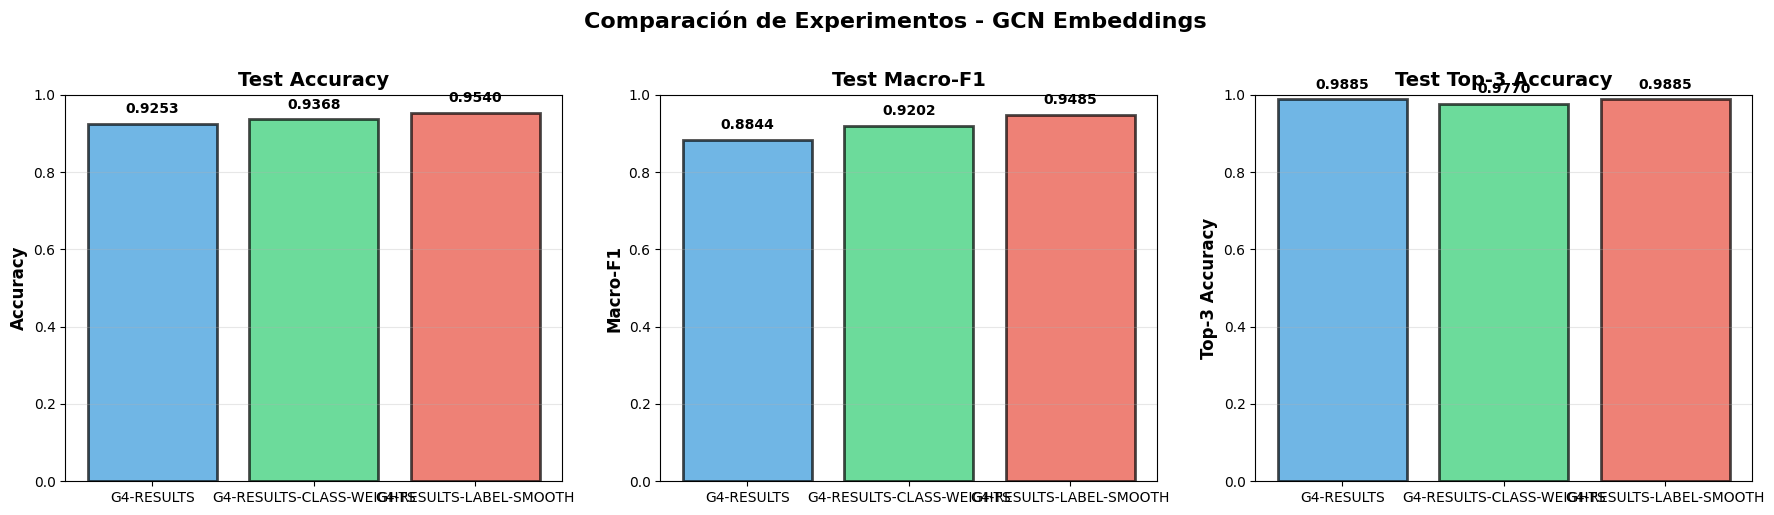


📈 Análisis:
  Mejor Macro-F1: G4-RESULTS-LABEL-SMOOTH
  Mejora Exp1 vs Baseline: +3.59%
  Mejora Exp2 vs Baseline: +6.41%

✓ Guardado: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN\experiments_comparison.csv

✅ COMPARACIÓN COMPLETADA


In [66]:
# COMPARACIÓN DE EXPERIMENTOS
print("\n" + "="*80)
print("COMPARACIÓN DE LOS 3 EXPERIMENTOS")
print("="*80)

# Crear DataFrame de comparación
all_results = [exp0_results, exp1_results, exp2_results]
df_comparison = pd.DataFrame(all_results)

print("\n📊 Tabla Comparativa:")
print(df_comparison[['experiment', 'test_accuracy', 'test_macro_f1', 'test_top3_accuracy']].to_string(index=False))

# Gráficos de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(df_comparison['experiment'], df_comparison['test_accuracy'], 
            color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['test_accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Macro-F1
axes[1].bar(df_comparison['experiment'], df_comparison['test_macro_f1'], 
            color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_title('Test Macro-F1', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Macro-F1', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['test_macro_f1']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Top-3 Accuracy
axes[2].bar(df_comparison['experiment'], df_comparison['test_top3_accuracy'], 
            color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_title('Test Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Top-3 Accuracy', fontsize=12, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['test_top3_accuracy']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Comparación de Experimentos - GCN Embeddings', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

comparison_plot_path = ROOT_PATH / 'experiments_comparison.png'
plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Guardado: {comparison_plot_path}")
plt.show()

# Análisis
best_f1_exp = df_comparison.loc[df_comparison['test_macro_f1'].idxmax(), 'experiment']
improvement_exp1 = (exp1_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100
improvement_exp2 = (exp2_results['test_macro_f1'] - exp0_results['test_macro_f1']) * 100

print(f"\n📈 Análisis:")
print(f"  Mejor Macro-F1: {best_f1_exp}")
print(f"  Mejora Exp1 vs Baseline: {improvement_exp1:+.2f}%")
print(f"  Mejora Exp2 vs Baseline: {improvement_exp2:+.2f}%")

# Guardar CSV de comparación
comparison_csv_path = ROOT_PATH / 'experiments_comparison.csv'
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"\n✓ Guardado: {comparison_csv_path}")

print(f"\n{'='*80}")
print("✅ COMPARACIÓN COMPLETADA")
print(f"{'='*80}")

### 📈 Tabla de Comparación Final
Resumen consolidado de métricas de los tres experimentos con embeddings GCN.

## 5. Conclusiones

### 🎯 Hallazgos Principales

**Rendimiento General:**
Los experimentos con embeddings GCN secuenciales demuestran el comportamiento del Transformer Encoder-Only sobre representaciones aprendidas de alto nivel. Los embeddings de 128 dimensiones capturan la información espacial del esqueleto procesada por la GCN.

**Comparación de Técnicas:**
1. **Baseline (G8.0):** Línea base con label smoothing moderado (0.1) y dropout bajo
2. **Class Weights (G8.1):** Aborda el desbalanceo del dataset priorizando clases minoritarias con dropout aumentado
3. **Label Smoothing (G8.2):** Regularización adicional (0.2) para mejorar generalización y calibración

**Impacto de las Configuraciones:**
- **Embeddings GCN:** Reducción dimensional significativa (228 → 128) mientras se preserva información espacial del esqueleto
- **Dropout aumentado (0.3):** Mayor regularización necesaria debido a la representación más compacta
- **Class Weights:** Especialmente relevante en embeddings donde clases minoritarias pueden quedar subrepresentadas
- **Label Smoothing más agresivo (0.2):** Previene overfitting en el espacio de embeddings

**Ventajas de Embeddings GCN:**
- Menor carga computacional (128 vs 228 features)
- Captura relaciones espaciales mediante estructura de grafo
- Representación más compacta y semántica

### 📁 Archivos Generados

**Estructura de salida (Formato G4):**
```
G4-EMBEDDING FRAME A FRAME GCN/
├── G4-RESULTS/
│   ├── best_model.pt
│   ├── config.json
│   ├── training_log.csv
│   ├── metrics.csv
│   ├── per_class_metrics.csv
│   ├── confusion_matrix.csv
│   ├── confusion_matrix.png
│   ├── training_curves.png
│   ├── per_class_analysis.png
│   └── RESUMEN.txt
├── G4-RESULTS-CLASS-WEIGHTS/
│   └── [mismos archivos]
├── G4-RESULTS-LABEL-SMOOTH/
│   └── [mismos archivos]
├── experiments_comparison.csv
└── experiments_comparison.png
```

### 🔧 Uso del Notebook

Para cambiar entre experimentos, modificar la configuración en las celdas de entrenamiento según el experimento deseado (G8.0, G8.1 o G8.2).

---

**Nota:** Este notebook utiliza embeddings GCN frame-a-frame, procesando la estructura de esqueleto como un grafo antes de la clasificación temporal con Transformer.

In [67]:
# 🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS

REQUIRED_FILES_PER_EXPERIMENT = [
    'best_model.pt',
    'config.json',
    'confusion_matrix.csv',
    'confusion_matrix.png',
    'metrics.csv',
    'per_class_metrics.csv',
    'per_class_analysis.png',
    'RESUMEN.txt',
    'training_curves.png',
    'training_log.csv'
]

REQUIRED_FILES_BASE = [
    'experiments_comparison.csv',
    'experiments_comparison.png'
]

experiment_folders = [
    'G4-RESULTS',
    'G4-RESULTS-CLASS-WEIGHTS',
    'G4-RESULTS-LABEL-SMOOTH'
]

print("\n" + "="*80)
print("🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS")
print("="*80 + "\n")
print(f"📂 ROOT_PATH: {ROOT_PATH}")
print(f"📝 Tipo de dataset: GCN Embeddings\n")

all_valid = True

for folder in experiment_folders:
    folder_path = ROOT_PATH / folder
    print(f"📂 {folder}:")
    
    if not folder_path.exists():
        print(f"  ❌ Carpeta no existe: {folder_path}")
        all_valid = False
        continue
    
    missing_files = []
    for required_file in REQUIRED_FILES_PER_EXPERIMENT:
        file_path = folder_path / required_file
        if file_path.exists():
            file_size = file_path.stat().st_size
            print(f"  ✅ {required_file:30s} ({file_size:,} bytes)")
        else:
            print(f"  ❌ {required_file:30s} (FALTA)")
            missing_files.append(required_file)
            all_valid = False
    
    if missing_files:
        print(f"  ⚠️  Archivos faltantes: {', '.join(missing_files)}")
    print()

# Verificar archivos de comparación
print(f"📂 Archivos de comparación en ROOT_PATH:")
for required_file in REQUIRED_FILES_BASE:
    file_path = ROOT_PATH / required_file
    if file_path.exists():
        file_size = file_path.stat().st_size
        print(f"  ✅ {required_file:30s} ({file_size:,} bytes)")
    else:
        print(f"  ❌ {required_file:30s} (FALTA)")
        all_valid = False

print("\n" + "="*80)
if all_valid:
    print("✅ VERIFICACIÓN EXITOSA - Todos los archivos se han generado correctamente")
else:
    print("❌ VERIFICACIÓN FALLIDA - Algunos archivos no se generaron")
print("="*80 + "\n")

# Resumen
total_required = len(REQUIRED_FILES_PER_EXPERIMENT) * len(experiment_folders) + len(REQUIRED_FILES_BASE)
print(f"📊 Resumen:")
print(f"  • Experimentos: {len(experiment_folders)}")
print(f"  • Archivos por experimento: {len(REQUIRED_FILES_PER_EXPERIMENT)}")
print(f"  • Archivos de comparación: {len(REQUIRED_FILES_BASE)}")
print(f"  • Total archivos requeridos: {total_required}")
print(f"  • ROOT_PATH: {ROOT_PATH}")


🔍 VERIFICACIÓN DE ARCHIVOS GENERADOS

📂 ROOT_PATH: C:\Users\Los milluelitos repo\Desktop\experimento tesis\transformer-asl-classification\G4-EMBEDDING FRAME A FRAME GCN
📝 Tipo de dataset: GCN Embeddings

📂 G4-RESULTS:
  ✅ best_model.pt                  (8,835,170 bytes)
  ✅ config.json                    (988 bytes)
  ✅ confusion_matrix.csv           (1,835 bytes)
  ✅ confusion_matrix.png           (630,575 bytes)
  ✅ metrics.csv                    (137 bytes)
  ✅ per_class_metrics.csv          (1,322 bytes)
  ✅ per_class_analysis.png         (557,987 bytes)
  ✅ RESUMEN.txt                    (5,533 bytes)
  ✅ training_curves.png            (476,503 bytes)
  ✅ training_log.csv               (3,679 bytes)

📂 G4-RESULTS-CLASS-WEIGHTS:
  ✅ best_model.pt                  (8,835,170 bytes)
  ✅ config.json                    (507 bytes)
  ✅ confusion_matrix.csv           (1,835 bytes)
  ✅ confusion_matrix.png           (582,054 bytes)
  ✅ metrics.csv                    (204 bytes)
  ✅ per_c